# Chapter 7: Cross-Validation in Finance

This notebook demonstrates the cross-validation techniques from **Advances in Financial Machine Learning** (AFML) Chapter 7.

## Why This Matters

Cross-validation is essential for evaluating ML models, but **standard k-fold CV fails catastrophically in finance**. This chapter explains why and provides solutions.

## Table of Contents

1. [The Problem: Why Standard CV Fails](#1.-The-Problem:-Why-Standard-CV-Fails)
2. [Understanding Overlapping Labels](#2.-Understanding-Overlapping-Labels)
3. [Purging: Removing Overlapping Observations](#3.-Purging:-Removing-Overlapping-Observations)
4. [Embargo: Handling Serial Correlation](#4.-Embargo:-Handling-Serial-Correlation)
5. [PurgedKFold: The Solution](#5.-PurgedKFold:-The-Solution)
6. [Walk-Forward Cross-Validation](#6.-Walk-Forward-Cross-Validation)
7. [CV Scoring with Sample Weights](#7.-CV-Scoring-with-Sample-Weights)
8. [Comparing CV Methods](#8.-Comparing-CV-Methods)

---

In [1]:
# Add project root to path
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

# AFML cross-validation module
from afml.cross_validation import (
    # Purging functions
    get_train_times,
    find_overlapping_indices,
    count_overlapping_observations,
    # Embargo functions
    get_embargo_times,
    compute_embargo_indices,
    get_embargo_mask,
    get_embargoed_train_indices,
    # CV classes
    PurgedKFold,
    PurgedWalkForwardCV,
    # Scoring functions
    cv_score,
    cv_score_with_predictions,
    compare_cv_methods,
)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


## 1. The Problem: Why Standard CV Fails

### The IID Assumption

Standard k-fold cross-validation assumes observations are **Independent and Identically Distributed (IID)**. This means:

1. Each observation is independent of all others
2. All observations come from the same distribution

### Why Finance Violates IID

Financial data violates IID in two critical ways:

#### 1. Overlapping Labels

Labels in finance often span multiple time periods. For example:
- A label based on returns over the next 10 days
- A triple-barrier label that can extend for weeks

When labels overlap, information leaks between observations.

#### 2. Serial Correlation

Features at time $t$ are correlated with features at time $t+1$. Even if labels don't overlap, the features do.

### The Consequence: Information Leakage

When test observations share information with training observations:
- CV scores appear artificially high
- Models seem to perform well but fail in production
- Strategies backtest beautifully but lose money live

In [2]:
# Create synthetic financial data with overlapping labels
def create_financial_data(n_samples=1000, label_span_days=10):
    """
    Create synthetic financial data with overlapping labels.
    
    Each label spans `label_span_days` into the future,
    causing overlap between adjacent observations.
    """
    # Time index
    dates = pd.date_range('2020-01-01', periods=n_samples, freq='D')
    
    # Label times: each label spans from t0 to t0 + label_span_days
    label_end_dates = dates + pd.Timedelta(days=label_span_days)
    label_times = pd.Series(label_end_dates, index=dates)
    
    # Create features with serial correlation (like real financial data)
    # Feature 1: Random walk (highly autocorrelated)
    returns = np.random.randn(n_samples) * 0.02
    prices = 100 * np.exp(np.cumsum(returns))
    
    # Feature 2: Moving average (overlaps with future)
    ma_10 = pd.Series(prices).rolling(10).mean().values
    
    # Feature 3: Volatility (overlaps with future)
    vol_10 = pd.Series(returns).rolling(10).std().values
    
    # Create feature matrix
    X = np.column_stack([
        prices,
        np.nan_to_num(ma_10, nan=prices.mean()),
        np.nan_to_num(vol_10, nan=returns.std()),
        returns,
    ])
    
    # Create binary labels (up/down based on future returns)
    future_returns = np.roll(returns, -label_span_days)
    y = (future_returns > 0).astype(int)
    
    return X, y, label_times, dates

# Generate data
X, y, label_times, dates = create_financial_data(n_samples=1000, label_span_days=10)

print(f"Dataset shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")
print(f"\nLabel times example (first 5):")
print(label_times.head())

Dataset shape: (1000, 4)
Label distribution: [490 510]

Label times example (first 5):
2020-01-01   2020-01-11
2020-01-02   2020-01-12
2020-01-03   2020-01-13
2020-01-04   2020-01-14
2020-01-05   2020-01-15
Freq: D, dtype: datetime64[ns]


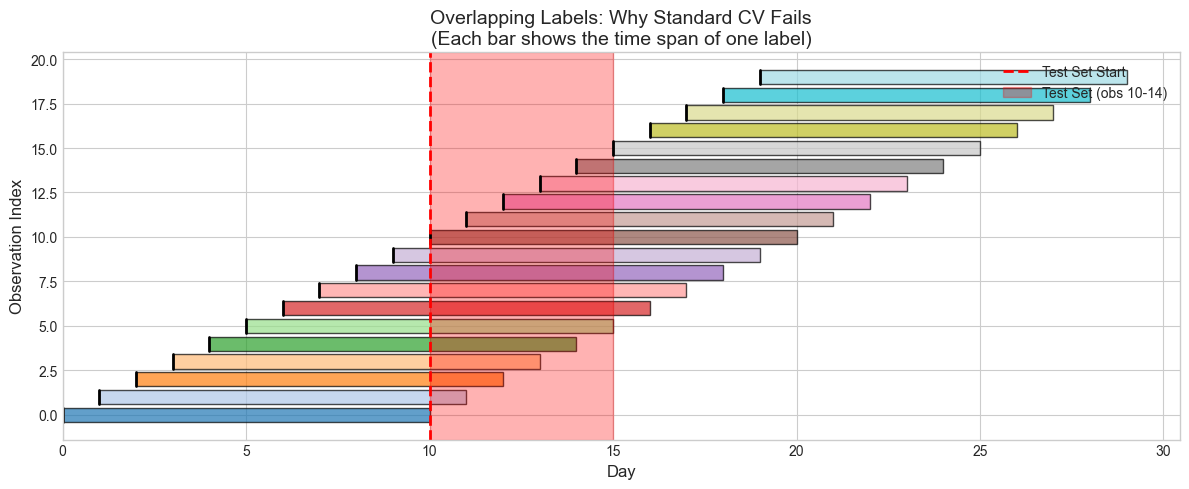

Notice how observations 0-9 have labels that extend INTO the test set (days 10-15).
This means training on observations 0-9 leaks information about the test set!


In [3]:
# Visualize the problem: overlapping labels
fig, ax = plt.subplots(figsize=(12, 5))

# Show first 20 observations and their label spans
n_show = 20
colors = plt.cm.tab20(np.linspace(0, 1, n_show))

for i in range(n_show):
    start = i  # Day index
    end = i + 10  # Label spans 10 days
    ax.barh(i, end - start, left=start, height=0.8, 
            color=colors[i], alpha=0.7, edgecolor='black')
    ax.plot([start, start], [i-0.4, i+0.4], 'k-', linewidth=2)

ax.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Test Set Start')
ax.axvspan(10, 15, alpha=0.3, color='red', label='Test Set (obs 10-14)')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Observation Index', fontsize=12)
ax.set_title('Overlapping Labels: Why Standard CV Fails\n(Each bar shows the time span of one label)', fontsize=14)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Notice how observations 0-9 have labels that extend INTO the test set (days 10-15).")
print("This means training on observations 0-9 leaks information about the test set!")

## 2. Understanding Overlapping Labels

### When Do Labels Overlap?

Consider two observations:
- **Training observation $i$**: Label spans $[t_{i,0}, t_{i,1}]$
- **Test observation $j$**: Label spans $[t_{j,0}, t_{j,1}]$

They overlap if **any** of these conditions is true:

1. **Train starts within test**: $t_{j,0} \leq t_{i,0} \leq t_{j,1}$
2. **Train ends within test**: $t_{j,0} \leq t_{i,1} \leq t_{j,1}$
3. **Train envelops test**: $t_{i,0} \leq t_{j,0}$ and $t_{j,1} \leq t_{i,1}$

### Impact on Training Set Size

Purging removes overlapping observations, which can significantly reduce the training set. Let's quantify this.

In [4]:
# Analyze overlap for different label spans
label_spans = [1, 5, 10, 20, 30, 50]
n_samples = 1000
test_size = 200  # 20% test set

results = []

for span in label_spans:
    # Create label times
    dates = pd.date_range('2020-01-01', periods=n_samples, freq='D')
    label_times = pd.Series(
        dates + pd.Timedelta(days=span),
        index=dates
    )
    
    # Define test set (middle 20%)
    test_start = n_samples // 2 - test_size // 2
    test_end = test_start + test_size
    test_times = label_times.iloc[test_start:test_end]
    
    # Count overlapping observations
    n_overlapping = count_overlapping_observations(label_times, test_times)
    
    # Calculate percentage of training data lost
    train_size_original = n_samples - test_size
    pct_lost = n_overlapping / train_size_original * 100
    
    results.append({
        'label_span_days': span,
        'n_overlapping': n_overlapping,
        'pct_training_lost': pct_lost,
        'effective_train_size': train_size_original - n_overlapping
    })

results_df = pd.DataFrame(results)
print("Impact of Label Span on Training Set Size")
print("="*55)
print(results_df.to_string(index=False))

Impact of Label Span on Training Set Size
 label_span_days  n_overlapping  pct_training_lost  effective_train_size
               1            202              25.25                   598
               5            210              26.25                   590
              10            220              27.50                   580
              20            240              30.00                   560
              30            260              32.50                   540
              50            300              37.50                   500


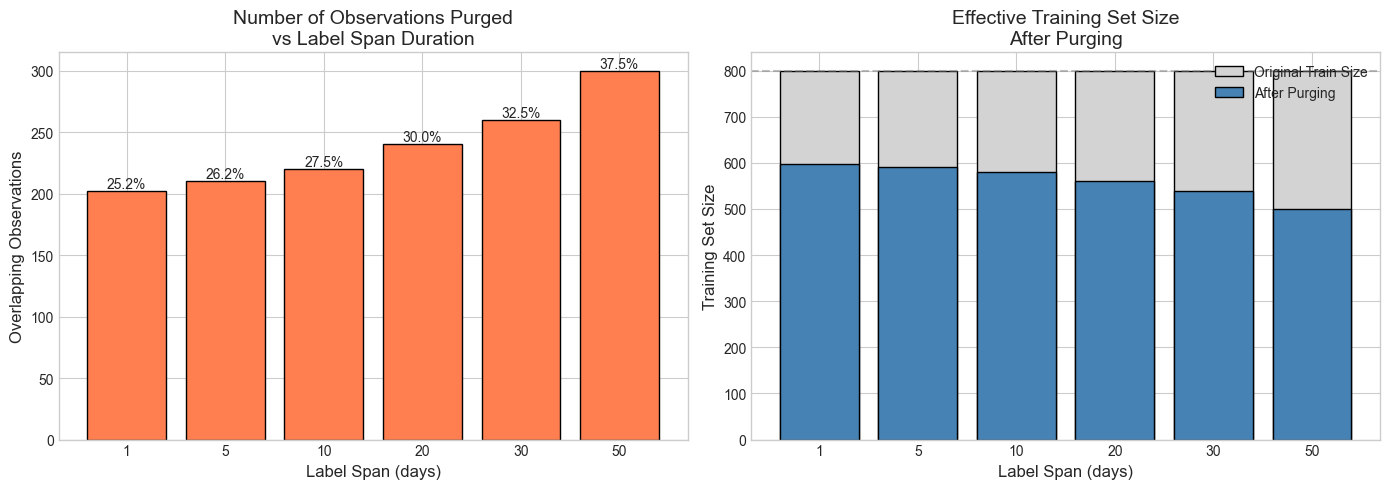


Key Insight: Longer label spans = more overlap = less training data
This is the price we pay for proper cross-validation in finance.


In [5]:
# Visualize the impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overlapping observations vs label span
ax1 = axes[0]
ax1.bar(results_df['label_span_days'].astype(str), results_df['n_overlapping'], 
        color='coral', edgecolor='black')
ax1.set_xlabel('Label Span (days)', fontsize=12)
ax1.set_ylabel('Overlapping Observations', fontsize=12)
ax1.set_title('Number of Observations Purged\nvs Label Span Duration', fontsize=14)

# Add percentage labels
for i, (span, pct) in enumerate(zip(results_df['label_span_days'], results_df['pct_training_lost'])):
    ax1.annotate(f'{pct:.1f}%', 
                 (i, results_df['n_overlapping'].iloc[i]), 
                 ha='center', va='bottom', fontsize=10)

# Plot 2: Effective training size
ax2 = axes[1]
train_original = n_samples - test_size
ax2.bar(results_df['label_span_days'].astype(str), 
        [train_original] * len(results_df), 
        color='lightgray', edgecolor='black', label='Original Train Size')
ax2.bar(results_df['label_span_days'].astype(str), 
        results_df['effective_train_size'], 
        color='steelblue', edgecolor='black', label='After Purging')
ax2.axhline(y=train_original, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Label Span (days)', fontsize=12)
ax2.set_ylabel('Training Set Size', fontsize=12)
ax2.set_title('Effective Training Set Size\nAfter Purging', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

print("\nKey Insight: Longer label spans = more overlap = less training data")
print("This is the price we pay for proper cross-validation in finance.")

## 3. Purging: Removing Overlapping Observations

### The Solution

**Purging** removes training observations whose labels overlap with any test observation. This prevents information leakage through overlapping labels.

### Implementation: `get_train_times()`

The function `get_train_times()` takes:
- `label_times`: All observation times (index=start, value=end)
- `test_times`: Test observation times

And returns the purged training times.

In [6]:
# Create example data
dates = pd.date_range('2020-01-01', periods=100, freq='D')
label_span = 10  # Each label spans 10 days

label_times = pd.Series(
    dates + pd.Timedelta(days=label_span),
    index=dates
)

# Define a test set (days 40-49)
test_indices = list(range(40, 50))
test_times = label_times.iloc[test_indices]

print("Test Set:")
print(f"  Observations: {test_indices[0]} to {test_indices[-1]}")
print(f"  Time range: {test_times.index[0].date()} to {test_times.iloc[-1].date()}")
print(f"  (Each label extends 10 days beyond its start)")
print()

# Find overlapping indices
overlapping = find_overlapping_indices(label_times, test_times)
print(f"Overlapping observations: {len(overlapping)}")
print(f"Indices: {sorted([label_times.index.get_loc(idx) for idx in overlapping])}")

Test Set:
  Observations: 40 to 49
  Time range: 2020-02-10 to 2020-02-29
  (Each label extends 10 days beyond its start)

Overlapping observations: 30
Indices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [7]:
# Demonstrate purging
train_times = get_train_times(label_times, test_times)

print("Before Purging:")
print(f"  Total observations: {len(label_times)}")
print(f"  Test observations: {len(test_times)}")
print(f"  Potential training: {len(label_times) - len(test_times)}")
print()
print("After Purging:")
print(f"  Training observations: {len(train_times)}")
print(f"  Removed (purged): {len(label_times) - len(test_times) - len(train_times)}")

Before Purging:
  Total observations: 100
  Test observations: 10
  Potential training: 90

After Purging:
  Training observations: 70
  Removed (purged): 20


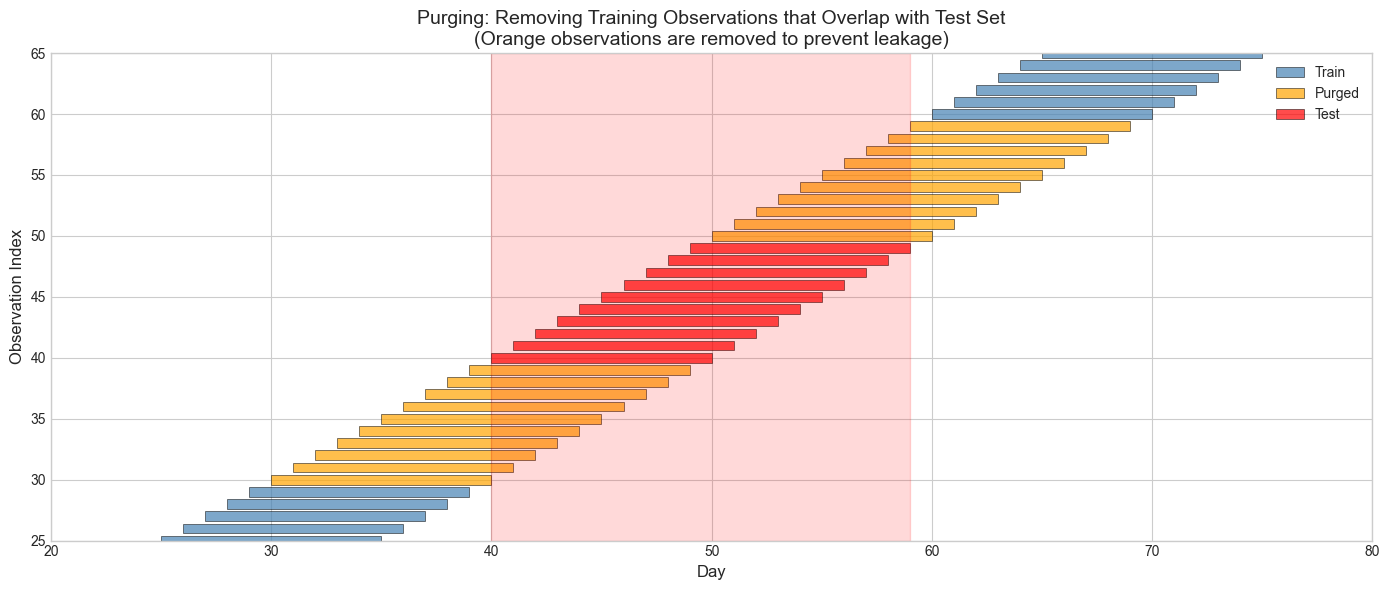

In [8]:
# Visualize purging
fig, ax = plt.subplots(figsize=(14, 6))

# Convert to indices for plotting
all_indices = np.arange(len(label_times))
test_idx_set = set(test_indices)
train_idx_set = set(label_times.index.get_loc(t) for t in train_times.index)
purged_idx_set = set(all_indices) - test_idx_set - train_idx_set

# Plot each observation
for i in all_indices:
    start = i
    end = i + label_span
    
    if i in test_idx_set:
        color = 'red'
        label = 'Test' if i == min(test_idx_set) else None
    elif i in purged_idx_set:
        color = 'orange'
        label = 'Purged' if i == min(purged_idx_set) else None
    else:
        color = 'steelblue'
        label = 'Train' if i == min(train_idx_set) else None
    
    ax.barh(i, end - start, left=start, height=0.8, 
            color=color, alpha=0.7, edgecolor='black', linewidth=0.5,
            label=label)

# Mark test set region
test_start_day = min(test_indices)
test_end_day = max(test_indices) + label_span  # Include label extension
ax.axvspan(test_start_day, test_end_day, alpha=0.15, color='red')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Observation Index', fontsize=12)
ax.set_title('Purging: Removing Training Observations that Overlap with Test Set\n'
             '(Orange observations are removed to prevent leakage)', fontsize=14)
ax.legend(loc='upper right')

# Focus on relevant region
ax.set_xlim(20, 80)
ax.set_ylim(25, 65)

plt.tight_layout()
plt.show()

## 4. Embargo: Handling Serial Correlation

### The Problem

Even after purging overlapping labels, there's still a problem: **features are serially correlated**.

Consider features at time $t$ and $t+1$:
- Moving averages overlap
- Volatility estimates share data
- Price levels are correlated

Training on observation $t+1$ when testing on $t$ still leaks information through correlated features.

### The Solution: Embargo Period

**Embargo** removes training observations that occur immediately **after** the test set. This creates a buffer zone where serially correlated features can't cause leakage.

Typical embargo: 1-2% of total observations.

In [9]:
# Demonstrate embargo calculation
n_samples = 1000
dates = pd.date_range('2020-01-01', periods=n_samples, freq='D')

# Different embargo percentages
embargo_pcts = [0.005, 0.01, 0.02, 0.05]

print("Embargo Period Calculation")
print("="*45)
print(f"{'Embargo %':<15} {'# Observations':<15} {'Days Skipped'}")
print("-"*45)

for pct in embargo_pcts:
    n_embargo = compute_embargo_indices(n_samples, pct)
    print(f"{pct*100:.1f}%{'':<11} {n_embargo:<15} {n_embargo} days")

print()
print("Recommendation: Use 1% embargo as a starting point.")

Embargo Period Calculation
Embargo %       # Observations  Days Skipped
---------------------------------------------
0.5%            5               5 days
1.0%            10              10 days
2.0%            20              20 days
5.0%            50              50 days

Recommendation: Use 1% embargo as a starting point.


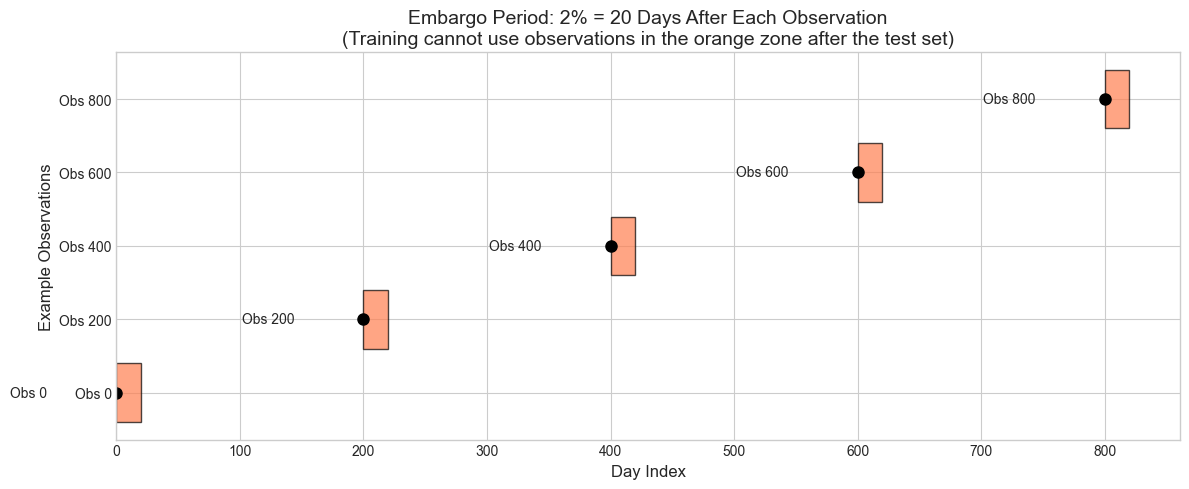

In [10]:
# Visualize embargo
embargo_pct = 0.02  # 2% embargo
embargo_times = get_embargo_times(dates, embargo_pct)

# Show how embargo extends the "forbidden" zone after each observation
fig, ax = plt.subplots(figsize=(12, 5))

# Sample observations
sample_indices = [0, 200, 400, 600, 800]

for i, idx in enumerate(sample_indices):
    obs_date = dates[idx]
    embargo_end = embargo_times[obs_date]
    
    # Time span from observation to embargo end
    days_until_embargo_end = (embargo_end - obs_date).days
    
    # Plot
    ax.barh(i, days_until_embargo_end, left=idx, 
            color='coral', alpha=0.7, edgecolor='black')
    ax.plot(idx, i, 'ko', markersize=8)  # Observation point
    
    # Annotation
    ax.annotate(f'Obs {idx}', (idx, i), xytext=(-50, 0), 
                textcoords='offset points', ha='right', va='center')

ax.set_xlabel('Day Index', fontsize=12)
ax.set_ylabel('Example Observations', fontsize=12)
ax.set_title(f'Embargo Period: {embargo_pct*100:.0f}% = {int(n_samples*embargo_pct)} Days After Each Observation\n'
             '(Training cannot use observations in the orange zone after the test set)', fontsize=14)
ax.set_yticks(range(len(sample_indices)))
ax.set_yticklabels([f'Obs {idx}' for idx in sample_indices])

plt.tight_layout()
plt.show()

In [11]:
# Show how embargo affects training indices
n_samples = 100
all_indices = np.arange(n_samples)
test_indices = np.array([40, 41, 42, 43, 44])  # 5 test observations
embargo_size = 5  # Embargo 5 observations after test

# Get training indices after embargo
train_indices = get_embargoed_train_indices(all_indices, test_indices, embargo_size)

print("Embargo Example")
print("="*50)
print(f"Total observations: {n_samples}")
print(f"Test indices: {test_indices}")
print(f"Embargo size: {embargo_size}")
print()
print(f"Test set ends at: {test_indices.max()}")
print(f"Embargo covers: {test_indices.max() + 1} to {test_indices.max() + embargo_size}")
print(f"Training can use: 0-{test_indices.min()-1} and {test_indices.max() + embargo_size + 1}-{n_samples-1}")
print()
print(f"Training set size: {len(train_indices)}")

Embargo Example
Total observations: 100
Test indices: [40 41 42 43 44]
Embargo size: 5

Test set ends at: 44
Embargo covers: 45 to 49
Training can use: 0-39 and 50-99

Training set size: 90


## 5. PurgedKFold: The Solution

### Combining Purging and Embargo

`PurgedKFold` extends scikit-learn's `KFold` to:

1. **Purge** training observations that overlap with test labels
2. **Embargo** training observations immediately after the test set

### Key Differences from Standard KFold

| Aspect | Standard KFold | PurgedKFold |
|--------|---------------|-------------|
| Shuffle | Optional | Never (temporal order matters) |
| Overlap handling | None | Purging removes overlaps |
| Serial correlation | Ignored | Embargo handles it |
| Training size | Fixed per fold | Varies (after purging) |

In [12]:
# Create data for PurgedKFold demonstration
X, y, label_times, dates = create_financial_data(n_samples=500, label_span_days=10)

# Create PurgedKFold
cv = PurgedKFold(
    n_splits=5,
    label_times=label_times,
    embargo_pct=0.01  # 1% embargo
)

print("PurgedKFold Configuration")
print("="*40)
print(f"Number of splits: {cv.n_splits}")
print(f"Embargo percentage: {cv.embargo_pct*100:.0f}%")
print(f"Total observations: {len(X)}")
print()

# Examine each fold
print("Fold Analysis")
print("-"*60)
print(f"{'Fold':<6} {'Train Size':<12} {'Test Size':<12} {'Train Range':<20}")
print("-"*60)

for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
    train_range = f"{train_idx.min()}-{train_idx.max()}"
    print(f"{fold+1:<6} {len(train_idx):<12} {len(test_idx):<12} {train_range:<20}")

PurgedKFold Configuration
Number of splits: 5
Embargo percentage: 1%
Total observations: 500

Fold Analysis
------------------------------------------------------------
Fold   Train Size   Test Size    Train Range         
------------------------------------------------------------
1      386          100          114-499             
2      377          100          0-499               
3      377          100          0-499               
4      377          100          0-499               
5      391          100          0-390               


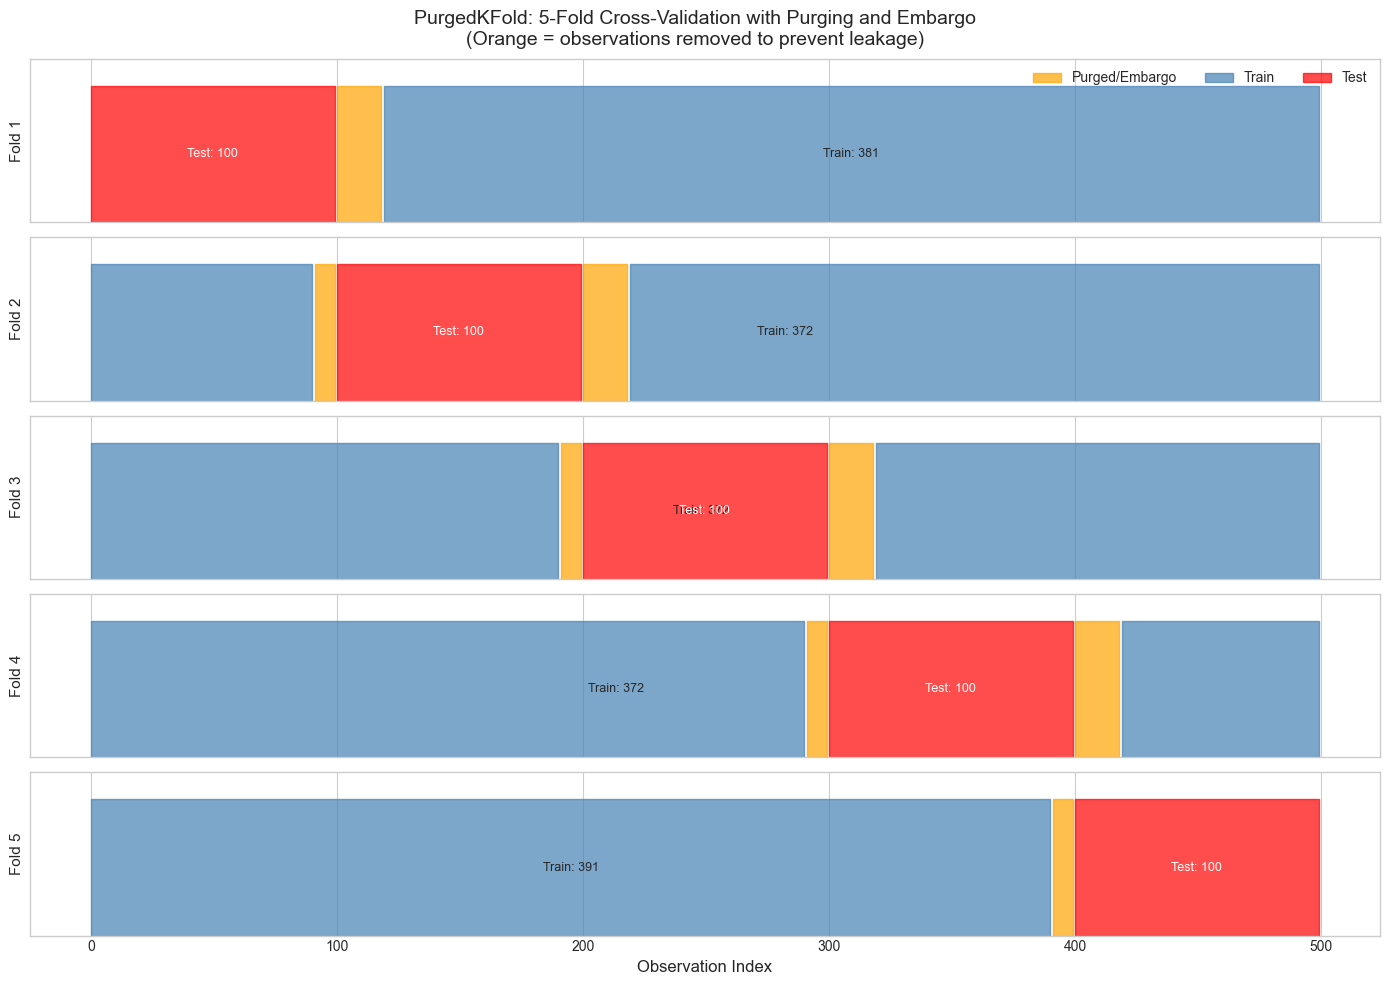

In [13]:
# Visualize PurgedKFold splits
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

cv = PurgedKFold(n_splits=5, label_times=label_times, embargo_pct=0.02)

for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
    ax = axes[fold]
    
    # Create status array
    status = np.zeros(len(X))
    status[train_idx] = 1  # Train
    status[test_idx] = 2   # Test
    # Remaining = 0 (purged/embargoed)
    
    # Plot as colored bars
    colors = ['orange', 'steelblue', 'red']
    labels = ['Purged/Embargo', 'Train', 'Test']
    
    for s in [0, 1, 2]:
        mask = status == s
        ax.fill_between(range(len(X)), 0, mask.astype(int), 
                       where=mask, color=colors[s], alpha=0.7,
                       label=labels[s] if fold == 0 else None)
    
    ax.set_ylabel(f'Fold {fold+1}', fontsize=11)
    ax.set_ylim(0, 1.2)
    ax.set_yticks([])
    
    # Add text annotations
    ax.text(train_idx.mean(), 0.5, f'Train: {len(train_idx)}', 
            ha='center', va='center', fontsize=9)
    ax.text(test_idx.mean(), 0.5, f'Test: {len(test_idx)}', 
            ha='center', va='center', fontsize=9, color='white')

axes[0].legend(loc='upper right', ncol=3)
axes[-1].set_xlabel('Observation Index', fontsize=12)
fig.suptitle('PurgedKFold: 5-Fold Cross-Validation with Purging and Embargo\n'
             '(Orange = observations removed to prevent leakage)', fontsize=14)

plt.tight_layout()
plt.show()

In [14]:
# Compare standard KFold vs PurgedKFold training sizes
n_splits = 5

# Standard KFold
standard_cv = KFold(n_splits=n_splits, shuffle=False)
standard_train_sizes = [len(train_idx) for train_idx, _ in standard_cv.split(X)]

# PurgedKFold with different embargo levels
embargo_levels = [0.0, 0.01, 0.02, 0.05]
purged_train_sizes = {}

for embargo in embargo_levels:
    cv = PurgedKFold(n_splits=n_splits, label_times=label_times, embargo_pct=embargo)
    sizes = [len(train_idx) for train_idx, _ in cv.split(X)]
    purged_train_sizes[f'{embargo*100:.0f}%'] = sizes

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'Standard KFold': standard_train_sizes,
})
for key, sizes in purged_train_sizes.items():
    comparison[f'PurgedKFold ({key} embargo)'] = sizes

print("Training Set Sizes: Standard vs Purged KFold")
print("="*70)
print(comparison.to_string(index=False))
print()
print("Note: PurgedKFold has smaller training sets due to purging and embargo.")
print("This is the cost of preventing information leakage.")

Training Set Sizes: Standard vs Purged KFold
 Fold  Standard KFold  PurgedKFold (0% embargo)  PurgedKFold (1% embargo)  PurgedKFold (2% embargo)  PurgedKFold (5% embargo)
    1             400                       391                       386                       381                       366
    2             400                       382                       377                       372                       357
    3             400                       382                       377                       372                       357
    4             400                       382                       377                       372                       357
    5             400                       391                       391                       391                       391

Note: PurgedKFold has smaller training sets due to purging and embargo.
This is the cost of preventing information leakage.


## 6. Walk-Forward Cross-Validation

### A More Realistic Approach

In production, we always:
- **Train on past data**
- **Test on future data**

Walk-forward CV simulates this by progressively moving the training and test windows forward in time.

### Structure

```
Split 1: [===Train===] [Test]
Split 2:    [===Train===] [Test]
Split 3:       [===Train===] [Test]
...
```

### Advantages

1. **Respects temporal order**: Always train on past, test on future
2. **Simulates deployment**: How the model would actually be used
3. **Detects regime changes**: Performance varies across different market periods

In [15]:
# Create Walk-Forward CV
wf_cv = PurgedWalkForwardCV(
    n_splits=5,
    train_pct=0.6,  # 60% training window
    label_times=label_times,
    embargo_pct=0.01
)

print("Walk-Forward CV Configuration")
print("="*40)
print(f"Number of splits: {wf_cv.n_splits}")
print(f"Training window: {wf_cv.train_pct*100:.0f}% of data")
print(f"Embargo: {wf_cv.embargo_pct*100:.0f}%")
print()

# Examine splits
print("Fold Analysis")
print("-"*70)
print(f"{'Fold':<6} {'Train Start':<12} {'Train End':<12} {'Test Start':<12} {'Test End':<12}")
print("-"*70)

for fold, (train_idx, test_idx) in enumerate(wf_cv.split(X)):
    print(f"{fold+1:<6} {train_idx.min():<12} {train_idx.max():<12} {test_idx.min():<12} {test_idx.max():<12}")

Walk-Forward CV Configuration
Number of splits: 5
Training window: 60% of data
Embargo: 1%

Fold Analysis
----------------------------------------------------------------------
Fold   Train Start  Train End    Test Start   Test End    
----------------------------------------------------------------------
1      0            289          300          339         
2      35           329          340          379         
3      75           369          380          419         
4      115          409          420          459         
5      155          449          460          499         


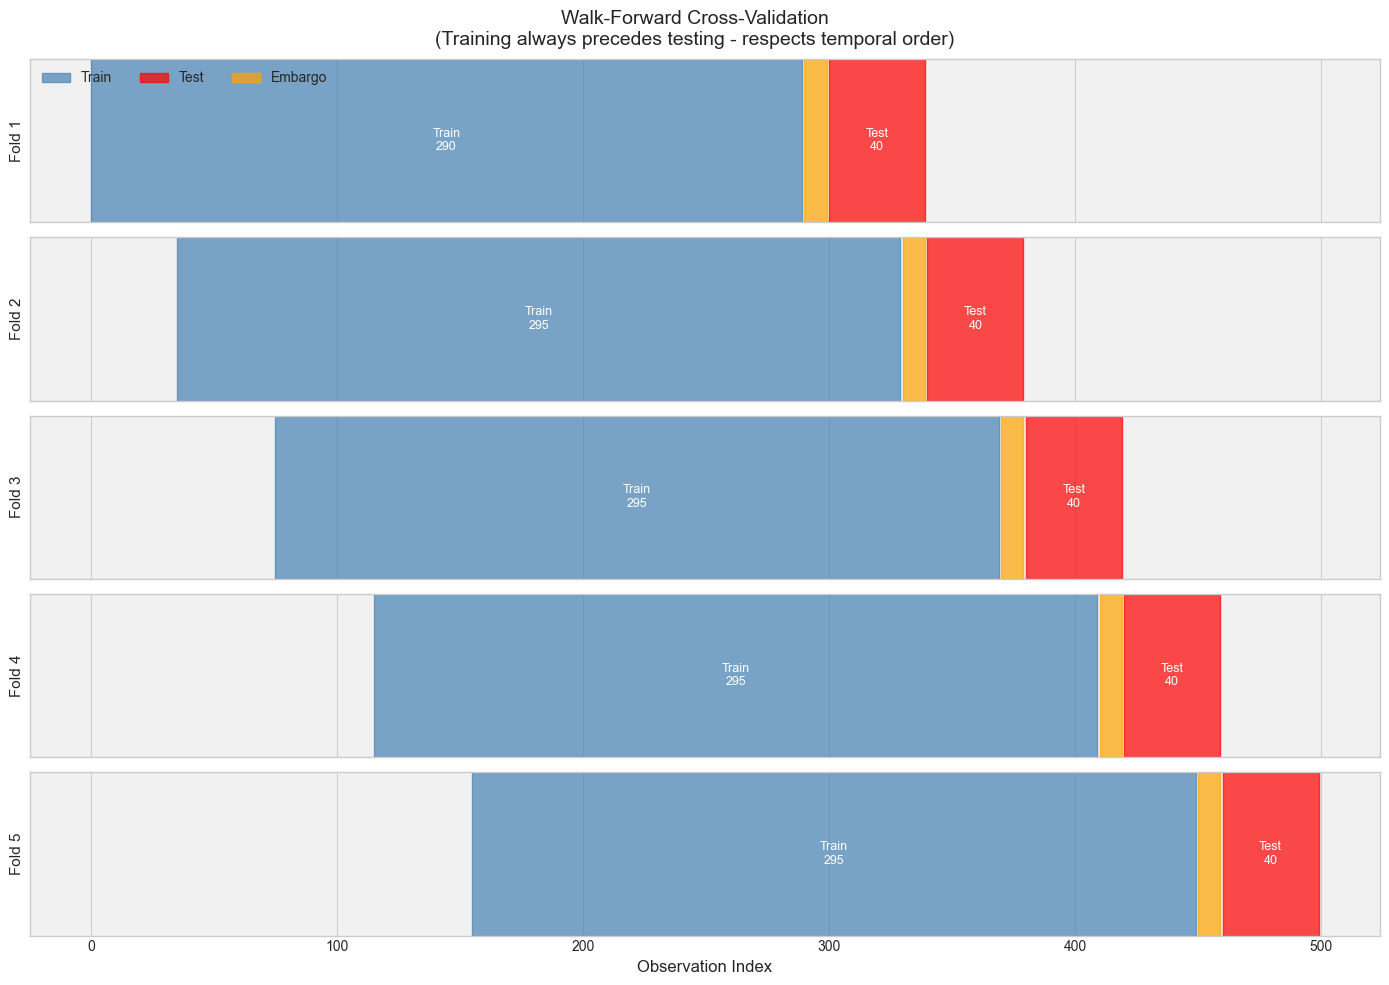

Note: Walk-forward CV always trains on past data and tests on future data.
This simulates how the model would be deployed in production.


In [16]:
# Visualize Walk-Forward CV
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

for fold, (train_idx, test_idx) in enumerate(wf_cv.split(X)):
    ax = axes[fold]
    
    # Background
    ax.axhspan(0, 1, color='lightgray', alpha=0.3)
    
    # Training region
    ax.axvspan(train_idx.min(), train_idx.max(), color='steelblue', alpha=0.7, label='Train' if fold == 0 else None)
    
    # Test region
    ax.axvspan(test_idx.min(), test_idx.max(), color='red', alpha=0.7, label='Test' if fold == 0 else None)
    
    # Embargo gap (between train and test)
    if train_idx.max() < test_idx.min() - 1:
        ax.axvspan(train_idx.max() + 1, test_idx.min() - 1, color='orange', alpha=0.7, label='Embargo' if fold == 0 else None)
    
    ax.set_ylabel(f'Fold {fold+1}', fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    
    # Annotations
    ax.text(train_idx.mean(), 0.5, f'Train\n{len(train_idx)}', 
            ha='center', va='center', fontsize=9, color='white')
    ax.text(test_idx.mean(), 0.5, f'Test\n{len(test_idx)}', 
            ha='center', va='center', fontsize=9, color='white')

axes[0].legend(loc='upper left', ncol=3)
axes[-1].set_xlabel('Observation Index', fontsize=12)
fig.suptitle('Walk-Forward Cross-Validation\n'
             '(Training always precedes testing - respects temporal order)', fontsize=14)

plt.tight_layout()
plt.show()

print("Note: Walk-forward CV always trains on past data and tests on future data.")
print("This simulates how the model would be deployed in production.")

## 7. CV Scoring with Sample Weights

### The sklearn Bug

There's a known bug in sklearn's `cross_val_score`:
- Sample weights are passed to `fit()`
- But NOT passed to the scoring function

This means weighted observations are used for training but not for evaluation!

### The Fix: `cv_score()`

Our `cv_score()` function properly handles sample weights in both training and scoring.

In [17]:
# Create sample weights (e.g., based on sample uniqueness)
# In practice, these come from the sample weights module
sample_weights = np.random.uniform(0.5, 1.5, size=len(y))

# Normalize weights
sample_weights = sample_weights / sample_weights.mean()

print("Sample Weight Statistics")
print("="*40)
print(f"Min weight: {sample_weights.min():.3f}")
print(f"Max weight: {sample_weights.max():.3f}")
print(f"Mean weight: {sample_weights.mean():.3f}")
print(f"Std weight: {sample_weights.std():.3f}")

Sample Weight Statistics
Min weight: 0.505
Max weight: 1.508
Mean weight: 1.000
Std weight: 0.289


In [18]:
# Compare cv_score with different scoring methods
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)

# Accuracy scoring
scores_acc = cv_score(
    clf, X, y,
    sample_weight=sample_weights,
    scoring='accuracy',
    label_times=label_times,
    n_splits=5,
    embargo_pct=0.01
)

# Log loss scoring
scores_ll = cv_score(
    clf, X, y,
    sample_weight=sample_weights,
    scoring='neg_log_loss',
    label_times=label_times,
    n_splits=5,
    embargo_pct=0.01
)

print("Cross-Validation Scores (with proper sample weighting)")
print("="*55)
print(f"\nAccuracy:")
print(f"  Per fold: {scores_acc}")
print(f"  Mean ± Std: {scores_acc.mean():.4f} ± {scores_acc.std():.4f}")
print(f"\nNegative Log Loss:")
print(f"  Per fold: {scores_ll}")
print(f"  Mean ± Std: {scores_ll.mean():.4f} ± {scores_ll.std():.4f}")

Cross-Validation Scores (with proper sample weighting)

Accuracy:
  Per fold: [0.51499521 0.49695625 0.47407975 0.57210437 0.4826385 ]
  Mean ± Std: 0.5082 ± 0.0349

Negative Log Loss:
  Per fold: [-0.68425376 -0.68334292 -0.72278273 -0.68343577 -0.72520681]
  Mean ± Std: -0.6998 ± 0.0198


In [19]:
# Get detailed predictions with cv_score_with_predictions
results = cv_score_with_predictions(
    clf, X, y,
    sample_weight=sample_weights,
    label_times=label_times,
    n_splits=5,
    embargo_pct=0.01
)

print("Detailed CV Results")
print("="*50)
print(f"\nLog Loss per fold: {results['scores_log_loss']}")
print(f"Accuracy per fold: {results['scores_accuracy']}")
print(f"\nPredictions DataFrame shape: {results['predictions'].shape}")
print(f"\nPredictions sample:")
print(results['predictions'].head(10))

if 'feature_importances' in results:
    print(f"\nFeature importances: {results['feature_importances']}")

Detailed CV Results

Log Loss per fold: [-0.68425376 -0.68334292 -0.72278273 -0.68343577 -0.72520681]
Accuracy per fold: [0.51499521 0.49695625 0.47407975 0.57210437 0.4826385 ]

Predictions DataFrame shape: (500, 5)

Predictions sample:
   fold  index  y_true  y_pred                                     y_prob
0     0      0       1       0  [0.5033769064980762, 0.49662309350192385]
1     0      1       1       1  [0.48240602968186813, 0.5175939703181319]
2     0      2       1       0    [0.5123329240512848, 0.487667075948715]
3     0      3       0       0  [0.5204543995405984, 0.47954560045940164]
4     0      4       1       0  [0.5202652911409446, 0.47973470885905534]
5     0      5       1       1  [0.49639943514757634, 0.5036005648524237]
6     0      6       0       1  [0.48240602968186813, 0.5175939703181319]
7     0      7       0       0  [0.5118433632963574, 0.48815663670364257]
8     0      8       0       1  [0.48963625670368477, 0.5103637432963152]
9     0      9       1

## 8. Comparing CV Methods

### The Impact of Proper CV

Let's compare:
1. **Standard KFold (no shuffle)**: Ignores overlap and correlation
2. **Standard KFold (shuffle)**: Even worse - mixes past and future
3. **PurgedKFold**: Proper handling of financial data

We expect:
- Standard CV to show **inflated** performance (due to leakage)
- PurgedKFold to show **realistic** performance

In [20]:
# Compare different CV methods
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)

comparison = compare_cv_methods(
    clf, X, y,
    label_times=label_times,
    sample_weight=sample_weights,
    n_splits=5,
    embargo_pct=0.01
)

print("CV Method Comparison")
print("="*75)
print(comparison.to_string(index=False))

CV Method Comparison
                      method  mean_accuracy  std_accuracy  min_accuracy  max_accuracy
Standard K-Fold (no shuffle)       0.526000      0.025768       0.48000      0.550000
   Standard K-Fold (shuffle)       0.544000      0.058172       0.49000      0.620000
  Purged K-Fold (1% embargo)       0.508155      0.034854       0.47408      0.572104


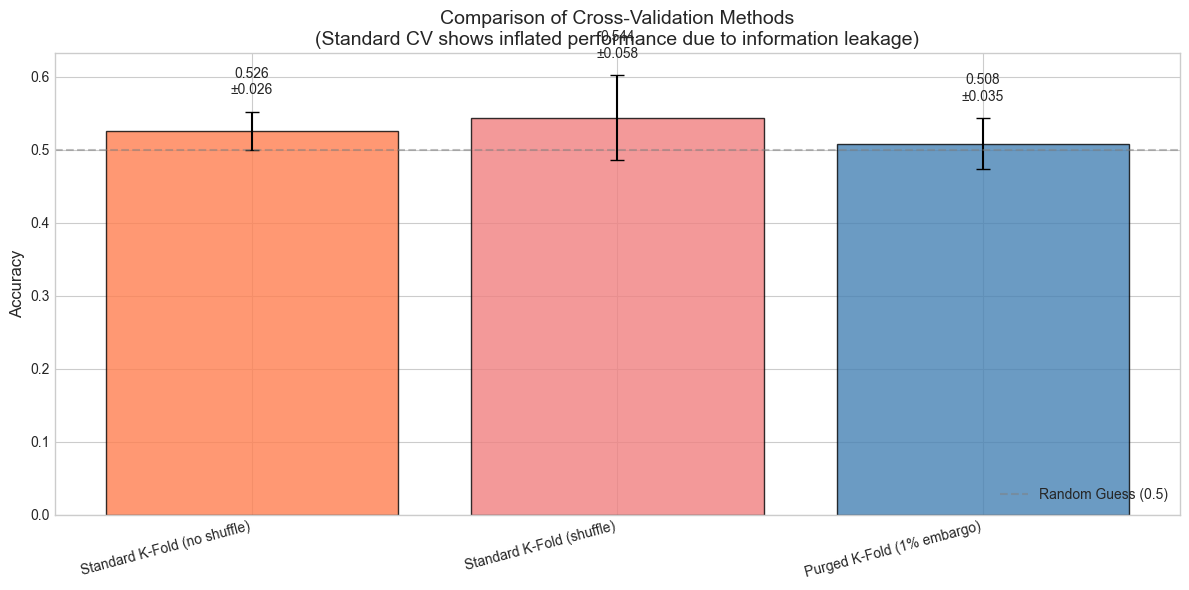


Key Observations:
- Standard CV (especially with shuffle) shows higher accuracy due to leakage
- PurgedKFold shows more realistic (often lower) performance
- The difference indicates how much standard CV overestimates performance


In [21]:
# Visualize the comparison
fig, ax = plt.subplots(figsize=(12, 6))

methods = comparison['method'].values
means = comparison['mean_accuracy'].values
stds = comparison['std_accuracy'].values

x = np.arange(len(methods))
colors = ['coral', 'lightcoral', 'steelblue']

bars = ax.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparison of Cross-Validation Methods\n'
             '(Standard CV shows inflated performance due to information leakage)', fontsize=14)

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.annotate(f'{mean:.3f}\n±{std:.3f}', 
                (i, mean + std + 0.02),
                ha='center', va='bottom', fontsize=10)

# Reference line at 0.5 (random guess for binary classification)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Guess (0.5)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Standard CV (especially with shuffle) shows higher accuracy due to leakage")
print("- PurgedKFold shows more realistic (often lower) performance")
print("- The difference indicates how much standard CV overestimates performance")

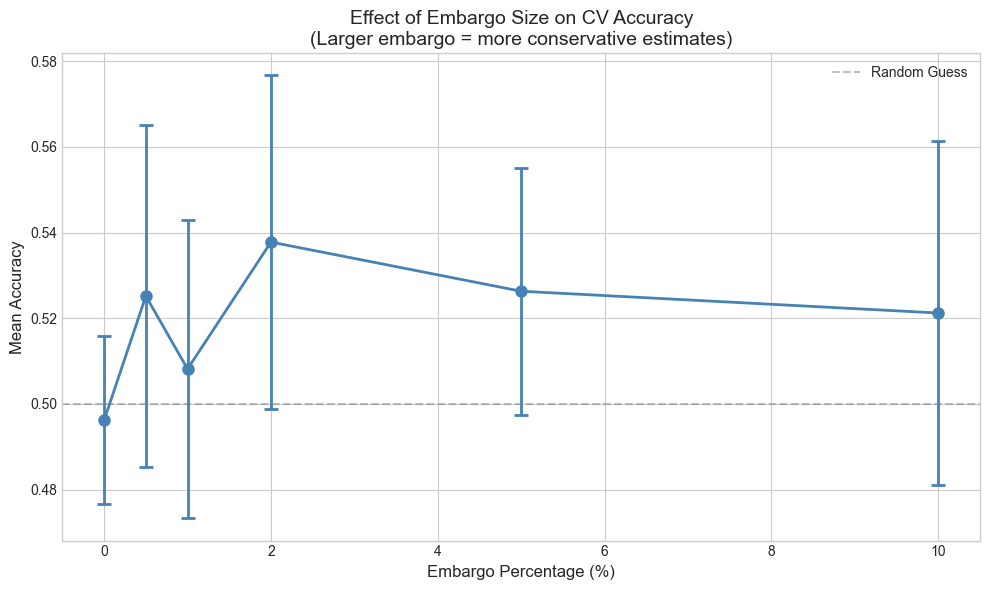

Embargo Size Analysis
 embargo_pct  mean_accuracy  std_accuracy
         0.0       0.496201      0.019579
         0.5       0.525181      0.039915
         1.0       0.508155      0.034854
         2.0       0.537770      0.038921
         5.0       0.526303      0.028840
        10.0       0.521219      0.040130


In [22]:
# Demonstrate the effect of embargo size
embargo_levels = [0.0, 0.005, 0.01, 0.02, 0.05, 0.10]
results_by_embargo = []

for embargo in embargo_levels:
    scores = cv_score(
        RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
        X, y,
        sample_weight=sample_weights,
        scoring='accuracy',
        label_times=label_times,
        n_splits=5,
        embargo_pct=embargo
    )
    results_by_embargo.append({
        'embargo_pct': embargo * 100,
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std()
    })

embargo_df = pd.DataFrame(results_by_embargo)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(
    embargo_df['embargo_pct'], 
    embargo_df['mean_accuracy'],
    yerr=embargo_df['std_accuracy'],
    marker='o', markersize=8, capsize=5, capthick=2,
    color='steelblue', linewidth=2
)

ax.set_xlabel('Embargo Percentage (%)', fontsize=12)
ax.set_ylabel('Mean Accuracy', fontsize=12)
ax.set_title('Effect of Embargo Size on CV Accuracy\n'
             '(Larger embargo = more conservative estimates)', fontsize=14)

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Guess')
ax.legend()

plt.tight_layout()
plt.show()

print("Embargo Size Analysis")
print("="*50)
print(embargo_df.to_string(index=False))

## Summary

### Key Takeaways

1. **Standard CV fails in finance** because observations are not IID
   - Labels overlap in time
   - Features are serially correlated

2. **Purging** removes training observations whose labels overlap with test
   - Prevents leakage through shared information
   - Reduces training set size

3. **Embargo** removes training observations after the test set
   - Handles serial correlation in features
   - Typical value: 1-2% of observations

4. **PurgedKFold** combines purging and embargo
   - Drop-in replacement for sklearn's KFold
   - Provides realistic performance estimates

5. **Walk-Forward CV** respects temporal order
   - Always trains on past, tests on future
   - Simulates production deployment

6. **cv_score()** fixes sklearn bugs
   - Properly passes sample weights to scoring
   - Handles classes_ information correctly

### Best Practices

1. **Always use PurgedKFold or Walk-Forward CV** for financial data
2. **Never shuffle** time series data in CV
3. **Use 1-2% embargo** as a starting point
4. **Monitor training set size** - too much purging may cause problems
5. **Compare CV methods** to understand the impact of leakage

In [23]:
print("Cross-Validation Tutorial Complete!")
print("="*50)
print("\nFunctions available in afml.cross_validation:")
print("\nPurging:")
print("  - get_train_times(): Purge overlapping training observations")
print("  - find_overlapping_indices(): Find which observations overlap")
print("  - count_overlapping_observations(): Count purged observations")
print("\nEmbargo:")
print("  - get_embargo_times(): Compute embargo end times")
print("  - compute_embargo_indices(): Calculate embargo size")
print("  - get_embargoed_train_indices(): Get train indices after embargo")
print("\nCV Classes:")
print("  - PurgedKFold: K-Fold with purging and embargo")
print("  - PurgedWalkForwardCV: Walk-forward with purging")
print("\nScoring:")
print("  - cv_score(): Cross-validation with proper sample weights")
print("  - cv_score_with_predictions(): CV with detailed predictions")
print("  - compare_cv_methods(): Compare standard vs purged CV")

Cross-Validation Tutorial Complete!

Functions available in afml.cross_validation:

Purging:
  - get_train_times(): Purge overlapping training observations
  - find_overlapping_indices(): Find which observations overlap
  - count_overlapping_observations(): Count purged observations

Embargo:
  - get_embargo_times(): Compute embargo end times
  - compute_embargo_indices(): Calculate embargo size
  - get_embargoed_train_indices(): Get train indices after embargo

CV Classes:
  - PurgedKFold: K-Fold with purging and embargo
  - PurgedWalkForwardCV: Walk-forward with purging

Scoring:
  - cv_score(): Cross-validation with proper sample weights
  - cv_score_with_predictions(): CV with detailed predictions
  - compare_cv_methods(): Compare standard vs purged CV
